In [1]:
import torch
import numpy as np

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('mpg')

In [3]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train)
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train)

initial loss:  932.87060546875
final loss:  2.4103446006774902
initial loss:  892.1621704101562
final loss:  2.3274710178375244
initial loss:  739.441650390625
final loss:  2.4395484924316406
initial loss:  1024.441650390625
final loss:  2.352902889251709
initial loss:  814.9332885742188
final loss:  2.3675739765167236
final loss:  2.9381067752838135


Deep ensemble test MAPE:  0.077699706
Deep ensemble test RMSE:  2.5463219
Deep ensemble test NLLK:  2.5690022
Deep ensemble test CRPS:  tensor(1.2991)


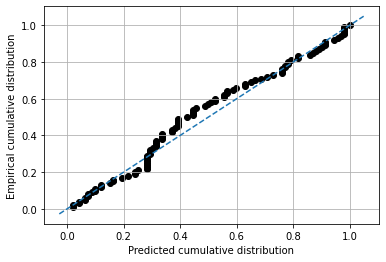

Deep ensemble test calibration error when step size is 0.001:  1.929130434782609
Deep ensemble test calibration error when step size is 0.01:  0.18946597353497174
Deep ensemble test calibration error when step size is 0.1:  0.01930529300567109


In [4]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

Concrete dropout test MAPE:  0.08890634
Concrete dropout test RMSE:  2.7059848
Concrete dropout test NLLK:  2.892614
Concrete dropout test CRPS:  tensor(1.4806)


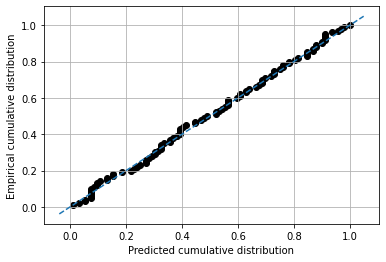

Concrete dropout test calibration error when step size is 0.001:  0.2762419659735351
Concrete dropout test calibration error when step size is 0.01:  0.026876181474480173
Concrete dropout test calibration error when step size is 0.1:  0.0016304347826086958


In [5]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy())
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))